# Compare methods using Squair data

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import functools
import numpy as np
import scanpy as sc
pd.set_option('display.max_rows', 100)

In [25]:
data_path = '/data_volume/memento/method_comparison/squair/'

In [28]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg')
import memento

In [26]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [27]:
pal = [(64/255,224/255,208/255)]+sns.color_palette("Greys", 10)[4:]

### Compute the concordance curve

In [6]:
def concordance_curve(refs, x, k=300):
    overlap = []
    for i in range(1, k+1):
        
        ref_total = 0
        for ref in refs:
            ref_total += len(set(x[:i]) & set(ref[:i]))
        overlap.append(ref_total/len(refs))
        
    return np.arange(1, k+1), np.array(overlap)

In [7]:
def concordance_auc(refs, x, k=300):
    count = 0
    for i in range(1, k+1):
        
        ref_total = 0
        for ref in refs:
            ref_total += len(set(x[:i]) & set(ref[:i]))
            
        count += ref_total/len(refs)
        
    return count / (k*(k+1)/2)

### Read results - cell type comparison

In [10]:
datasets = [
    'Hagai2018_mouse-lps',
    'Hagai2018_mouse-pic',
    'Hagai2018_pig-lps',
    'Hagai2018_rabbit-lps',
    'Hagai2018_rat-lps',
    'Hagai2018_rat-pic',
]

bulk_methods = [
    ('deseq2_lrt',['log2FoldChange', 'pvalue', 'padj']),
    ('deseq2_wald',['log2FoldChange', 'pvalue', 'padj']),
    ('edger_lrt',['logFC', 'PValue', 'FDR']),
    ('edger_qlft',['logFC', 'PValue', 'FDR']),
    # ('bulk_limma,mode?voom',['gene', 'logFC', 'P.Value', 'adj.P.Val'])
]

sc_methods = [ 
    # ('LR',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('MAST',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('bimod',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('negbinom',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('poisson',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('deseq2_lrt',['log2FoldChange', 'pvalue', 'p_val_adj']),
    # ('deseq2_wald',['log2FoldChange', 'pvalue', 'padj']),
    ('edger_lrt',['logFC', 'PValue', 'FDR']),
    ('mem_edger_lrt',['logFC', 'PValue', 'FDR']),
    # ('edger_qlft',['logFC', 'PValue', 'FDR']),
    # ('pseudobulk_limma,mode?voom',['gene','avg_logFC', 'p_val', 'p_val_adj']),
    # ('t',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('wilcox',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('memento',['logFC', 'PValue', 'FDR']), # full cells
]

In [18]:
def read_bulk_dataset(dataset, method, cols):
    
    df = pd.read_csv(data_path + 'bulk_rnaseq/results/{}_{}.csv'.format(dataset, method), index_col=0)[cols]
    df.columns = ['logFC','PValue', 'FDR']
    # df.index = df['gene']
    return df

def read_sc_dataset(dataset, method, cols):
    
    df = pd.read_csv(data_path +  'sc_rnaseq/results/{}_{}.csv'.format(dataset, method), index_col=0 if 'memento' not in method else 3)[cols]
    df.columns = ['logFC','PValue', 'FDR']
    # df.index = df['gene']
    return df

all_results = []
for dataset in datasets:
    print(dataset)
    bulk_results = [read_bulk_dataset(dataset, method, cols) for method, cols in bulk_methods]
    sc_results = [read_sc_dataset(dataset, method, cols) for method, cols in sc_methods]
    
    gene_list = gene_lists = [set(res.index) for res in sc_results] + [set(res.index) for res in bulk_results]
    genes = list(functools.reduce(lambda x,y: x & y, gene_lists))

    bulk_results = [res.loc[genes].sort_values('FDR') for res in bulk_results]
    sc_results = [res.loc[genes].sort_values('FDR') for res in sc_results]
    
    scores = [(sc_methods[idx][0], dataset, concordance_auc([b_res.index for b_res in bulk_results], res.index, k=100)) for idx, res in enumerate(sc_results)]
    all_results+=scores
    
    break

Hagai2018_mouse-lps


In [12]:
df = pd.DataFrame(all_results, columns=['name', 'numcells', 'auc'])

In [13]:
df

,name,numcells,auc
0,edger_lrt,Hagai2018_mouse-lps,0.441238
1,mem_edger_lrt,Hagai2018_mouse-lps,0.449901
2,edger_lrt,Hagai2018_mouse-pic,0.262376
3,mem_edger_lrt,Hagai2018_mouse-pic,0.260000
4,edger_lrt,Hagai2018_pig-lps,0.256931
5,mem_edger_lrt,Hagai2018_pig-lps,0.255891
6,edger_lrt,Hagai2018_rabbit-lps,0.206040
7,mem_edger_lrt,Hagai2018_rabbit-lps,0.197921
8,edger_lrt,Hagai2018_rat-lps,0.468861
9,mem_edger_lrt,Hagai2018_rat-lps,0.464851


In [14]:
df.groupby('name')['auc'].mean()

name
edger_lrt        0.334728
mem_edger_lrt    0.333449
Name: auc, dtype: float64

<Axes: xlabel='auc', ylabel='name'>

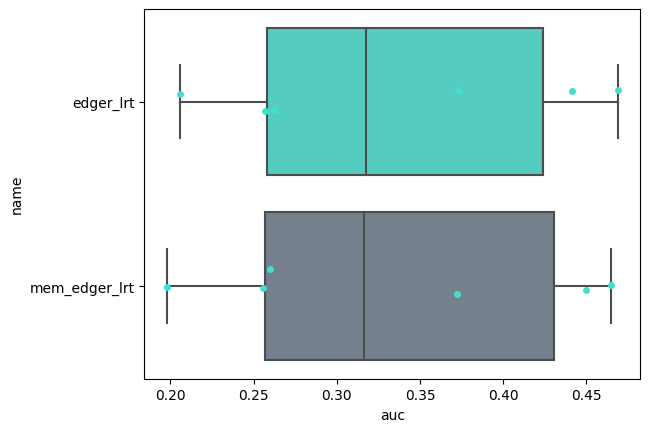

In [15]:
sns.boxplot(y='name', x='auc', data=df)
sns.stripplot(y='name', x='auc', data=df)

In [16]:
len(genes)

11207

### Where do pseudobulk methods fail?

In [152]:
file = datasets[0]
adata = sc.read_h5ad(data_path + 'sc_rnaseq/h5Seurat/' + file + '.csv')
adata.obs['q'] = 0.07
memento.setup_memento(adata, q_column='q', trim_percent=0.05,filter_mean_thresh=0.01)

In [153]:
memento.create_groups(adata, label_columns=['replicate', 'label'])
memento.compute_1d_moments(adata, )

In [173]:
bulk = bulk_results[2]
pb = sc_results[0]

bulk_dispersions = pd.read_csv(data_path + 'bulk_rnaseq/results/{}_bulk_dispersions.csv'.format(file), index_col=1)[['dispersion']]
pb_dispersions = pd.read_csv(data_path + 'sc_rnaseq/results/{}_dispersions.csv'.format(file), index_col=1)[['dispersion']]

In [176]:
bulk = bulk.join(bulk_dispersions, how='left')
pb = pb.join(pb_dispersions, how='left')

bulk['rank'] = np.arange(1, bulk.shape[0]+1)
pb['rank'] = np.arange(1, pb.shape[0]+1)

In [154]:
false_positives = list(set(bulk.query('rank > 300').index) & set(pb.query('rank < 300').index))
false_negatives = list(set(bulk.query('rank < 300').index) & set(pb.query('rank > 300').index))

In [155]:
moments = memento.get_1d_moments(adata, groupby='label')

In [156]:
def classify(x):
    
    if x in false_positives:
        return 'FP'
    elif x in false_negatives:
        return 'FN'
    else:
        return 'R'

In [157]:
rv_df = moments[1]
rv_df['diff'] = rv_df['label_lps4'] - rv_df['label_unst']
rv_df['diff_mag'] = rv_df['diff'].abs()
rv_df['mean'] = (rv_df['label_lps4'] + rv_df['label_unst'])/2
rv_df['category'] = rv_df['gene'].apply(classify)

<Axes: xlabel='category', ylabel='mean'>

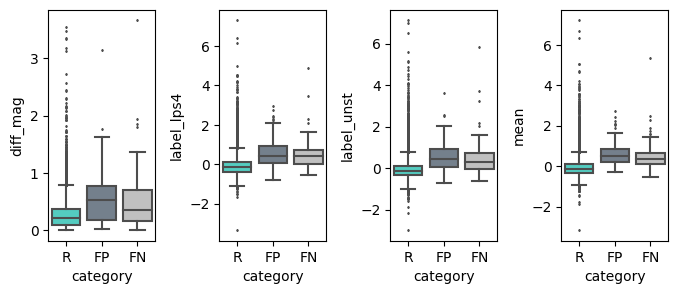

In [158]:
plt.figure(figsize=(8,3))
plt.subplots_adjust(wspace=0.6)
plt.subplot(1, 4, 1)
sns.boxplot(x='category', y='diff_mag', data=rv_df, fliersize=1)
plt.subplot(1, 4, 2)
sns.boxplot(x='category', y='label_lps4', data=rv_df, fliersize=1)
plt.subplot(1, 4, 3)
sns.boxplot(x='category', y='label_unst', data=rv_df, fliersize=1)
plt.subplot(1, 4, 4)
sns.boxplot(x='category', y='mean', data=rv_df, fliersize=1)

In [245]:
dispersions = bulk.join(pb, how='inner', lsuffix='_bulk', rsuffix='_pb')
dispersions['rank_diff'] = (dispersions['rank_bulk'] - dispersions['rank_pb'])
dispersions['dispersion_diff'] = dispersions['dispersion_bulk'] - dispersions['dispersion_pb']
dispersions['dispersion_ratio'] = np.log(dispersions['dispersion_bulk']/dispersions['dispersion_pb'])

In [246]:
stats.pearsonr(np.log(dispersions['dispersion_bulk']),np.log(dispersions['dispersion_pb']))

PearsonRResult(statistic=0.6794339476540648, pvalue=0.0)

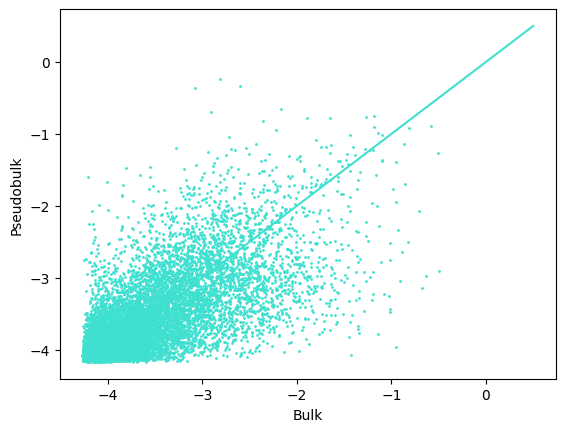

In [354]:
plt.scatter(np.log(dispersions['dispersion_bulk']),np.log(dispersions['dispersion_pb']), s=1)
plt.plot([-4, 0.5], [-4, 0.5])
plt.xlabel('Bulk');
plt.ylabel('Pseudobulk');
# plt.ylim(0, 0.4)

In [251]:
rv_df.index= rv_df['gene']

In [253]:
rv_disp = rv_df.join(joined, lsuffix='_rv', rsuffix='_disp')

In [254]:
def classify_rank(row):
    
    
    if row['rank_diff'] < -100 and row['rank_bulk'] < 300:
        return 'FN'
    elif row['rank_diff'] > 1000 and row['rank_bulk'] > 300:
        return 'FP'
    else:
        return 'R'

In [257]:
dispersions['category'] = joined.apply(classify_rank, axis=1).astype('category')

In [263]:
stats.pearsonr(rv_disp.dropna()['mean'], rv_disp.dropna()['dispersion_pb'])

PearsonRResult(statistic=0.29325745041469975, pvalue=1.821618094911185e-183)

In [264]:
stats.pearsonr(rv_disp.dropna()['mean'], rv_disp.dropna()['dispersion_bulk'])

PearsonRResult(statistic=0.26410840779744615, pvalue=6.411228110581866e-148)

In [265]:
stats.pearsonr(rv_disp.dropna()['dispersion_pb'], rv_disp.dropna()['dispersion_bulk'])

PearsonRResult(statistic=0.6201722396650046, pvalue=0.0)

<Axes: xlabel='category', ylabel='dispersion_ratio'>

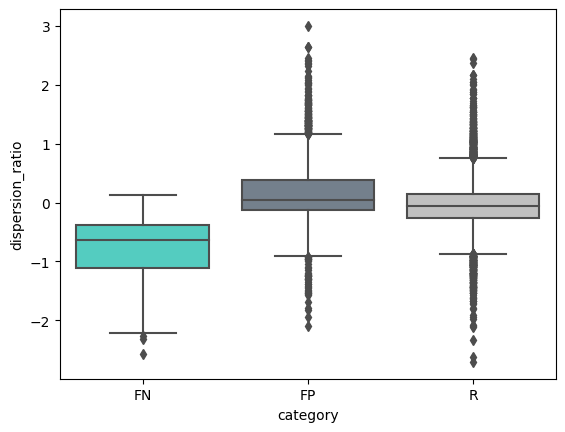

In [258]:
sns.boxplot(y='dispersion_ratio', x='category', data=dispersions)

### Memento derived dispersions

In [360]:
file = datasets[0]
adata = sc.read_h5ad(data_path + 'sc_rnaseq/h5Seurat/' + file + '.csv')
adata.obs['q'] = 0.9999
memento.setup_memento(adata, q_column='q', trim_percent=0.05,filter_mean_thresh=0.005)
adata.obs['memento_size_factor'] = 1

In [361]:
adata.obs['group'] = 'A'

In [362]:
memento.create_groups(adata, label_columns=['group'])
memento.compute_1d_moments(adata, )

In [363]:
# Create mean, variance df
moment_df = []
for group, moments in adata.uns['memento']['1d_moments'].items():
    
    df = pd.DataFrame()
    df['mean'] = moments[0]
    df['variance'] = moments[1]
    df['dispersion'] = (df['variance'] - df['mean'])/df['mean']**2
    df['sum'] = adata.uns['memento']['group_cells'][group].sum(axis=0).A1
    df['sum_dispersion'] = df['dispersion']/adata.uns['memento']['group_cells'][group].shape[0]
    # df['sampvar'] = moments[1]/adata.uns['memento']['group_cells'][group].shape[0]
    # df['replicate'] = group.split('^')[1]
    # df['stim'] = group.split('^')[2]
    df['gene'] = adata.var.index.tolist()
    # df['total'] = adata.uns['memento']['group_cells'][group].shape[0]
    moment_df.append(df)
moment_df = pd.concat(moment_df)


In [365]:
moment_df

,mean,variance,dispersion,sum,sum_dispersion,gene
0,0.322570,0.366551,0.422689,5734.0,0.000024,0610009B22Rik
1,0.047423,0.048883,0.648799,843.0,0.000036,0610009L18Rik
2,0.163929,0.176306,0.460592,2914.0,0.000026,0610010F05Rik
3,0.136307,0.145504,0.495000,2423.0,0.000028,0610010K14Rik
4,1.438344,2.472202,0.499730,25568.0,0.000028,0610012G03Rik
...,...,...,...,...,...,...
10860,0.081346,0.082596,0.188986,1446.0,0.000011,Zxdc
10861,0.132763,0.140776,0.454622,2360.0,0.000026,Zyg11b
10862,0.853342,1.850312,1.369104,15169.0,0.000077,Zyx
10863,0.221535,0.234654,0.267311,3938.0,0.000015,Zzef1


In [330]:
# dispersion calculation
moment_df['dispersion1'] = (moment_df['variance']*moment_df['total']**2-moment_df['mean']*moment_df['total'])/(moment_df['mean']*moment_df['total'])**2
moment_df['dispersion2'] = (moment_df['sampvar']*moment_df['total']**2-moment_df['mean']*moment_df['total'])/(moment_df['mean']*moment_df['total'])**2
moment_df['dispersion3'] = (moment_df['variance']-moment_df['mean'])/(moment_df['mean'])**2


In [358]:
moment_df.query('gene == "Gpr132"')['sum_dispersion']

3467    0.000219
3467    0.000504
3467    0.000157
3467    0.000201
3467    0.000176
3467    0.000147
Name: sum_dispersion, dtype: float64

In [353]:
dispersions.query('dispersion_pb < dispersion_bulk').shape[0]/dispersions.shape[0]

0.4322680225167968

In [352]:
dispersions.shape

(11014, 14)

In [303]:
false_negatives

['Cxcl3',
 'Serpinb2',
 'Lcn2',
 'Gpr132',
 'Rhbdf2',
 'Kcna3',
 'Il1f9',
 'Slc7a2',
 'Stat2',
 'Pim1',
 'Slfn5',
 'Maff',
 'Pstpip2',
 'Junb',
 'Rere',
 'Stxbp6',
 'Fpr2',
 'Gpr157',
 'Dusp4',
 'Enpp4',
 'Marcks',
 'Sesn1',
 'Ifi204',
 'Dyrk2',
 'Stx11',
 'Tmem154',
 'Wrb',
 'Cxcl2',
 'Ets2',
 'Gramd1a',
 'Gvin1',
 'Dnmt1',
 'Zfp558',
 'Plekhm1',
 'Map3k8',
 'Cebpa',
 'Ak4',
 'Phlda1',
 'Slfn2',
 'Nfatc2',
 'Ch25h',
 'Cdkn1a',
 'Cipc',
 'Pde4b',
 'Marcksl1',
 'Ccr2',
 'Parp12',
 'Inhba',
 'Ifi214',
 'Zfp395',
 'D16Ertd472e',
 'Tmem104',
 'Fpr1',
 'Ccsap',
 'Gm6377',
 'Rhov',
 'Il17ra',
 'Cxcl1',
 'Fbxo31',
 'Ppfia3',
 'Sh2d3c',
 'Vash2',
 'Lztfl1',
 'Samsn1',
 'Il1b',
 'Icosl',
 'Rasa2',
 'Spred1',
 'Ido2',
 'Pim3',
 'Lyl1',
 'Ptgs2',
 'Lacc1',
 'Fam214a',
 'Cdca7l',
 'Mapkbp1',
 'Abhd17c',
 'Gm4951',
 'Col11a2',
 'Agfg2',
 'Setd7',
 'Plxdc1',
 'Cd83',
 'Fosl2',
 'Gm4070',
 'Traf5',
 'Stard9',
 'Tef',
 'Pvr',
 'Trim13']

In [301]:
false_positives

['Tshz1',
 'Gbp4',
 'Otulinl',
 'Rcl1',
 'Susd6',
 'Oasl1',
 'Pilrb2',
 'Cemip2',
 'Met',
 'Sla',
 'Ifit3b',
 'Tcp11l2',
 'Tmem273',
 'Slc8b1',
 'Tsc22d3',
 'Slc31a2',
 'Malt1',
 'Ms4a6c',
 'Gcnt1',
 'Dtx2',
 'Slc25a37',
 'Ccnd2',
 'Six1',
 'Spryd7',
 'Ifit3',
 'Noct',
 'Clic4',
 'Gadd45b',
 'Msr1',
 'Slc15a3',
 '2200002D01Rik',
 'Hivep2',
 'Gem',
 'Src',
 'Cxcl10',
 'Cst7',
 'Tet2',
 'Il27',
 'Arid5a',
 'Pdcd4',
 'Igsf8',
 'Nupr1',
 'Lpar6',
 'Ifit2',
 'Pilrb1',
 'Rnd3',
 'Gas7',
 'Ypel3',
 'Mrgpre',
 'Fst',
 'Irf7',
 'Tpm4',
 'Phf11b',
 'Rassf4',
 'H2-Q6',
 'Slc43a2',
 'Oas2',
 'Denr',
 'Cfb',
 'AI467606',
 'Plaur',
 'Gca',
 'Slc26a11',
 'Oas1g',
 'Ccl9',
 'Dusp2',
 'Stip1',
 'Sntb1',
 'Cd69',
 'Flnb',
 'Cmpk2',
 'Snx30',
 'Paqr7',
 'Rsad2',
 'Marco',
 'Fas',
 'B3gnt8',
 'Pla2g4a',
 'Nampt',
 'Itgav',
 'Spry1',
 'Cerk',
 'Ifi35',
 'Il15',
 'Ptges',
 'Bin2',
 'Gmnn',
 'Tagln2',
 'Susd3',
 'Ccl12']

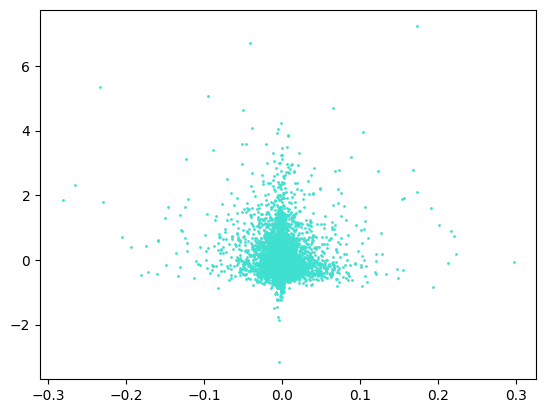

In [269]:
plt.scatter(rv_disp['dispersion_diff'], rv_disp['mean'], s=1)

In [134]:
name_paths = [
    ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.csv', ['log2FoldChange','pvalue', 'padj']),
    ('pseudobulk_edger','T4_vs_cM.pseudobulk.edger_lrt.csv', ['logFC','PValue', 'FDR']),
    ('pseudobulk_deseq2','T4_vs_cM.pseudobulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('ttest','T4_vs_cM.sc.ttest.csv', ['logFC','PValue', 'FDR']),
    # ('WLS','T4_vs_cM.sc.wls.csv', ['logFC','PValue', 'FDR']),
    ('sum_GLM', 'T4_vs_cM.sc.sum_glm.csv', ['logFC','PValue', 'FDR']),
    # ('scaled_mean_GLM', 'T4_vs_cM.sc.scaled_mean_glm.csv', ['logFC','PValue', 'FDR']),
    # ('scaled_iv_mean_GLM', 'T4_vs_cM.sc.scaled_iv_mean_glm.csv', ['logFC', 'PValue', 'FDR']),
    ('weighted_mean_GLM', 'T4_vs_cM.sc.weighted_mean_glm.csv', ['logFC','PValue', 'FDR']),
    ('memento', 'T4_vs_cM.sc.memento.csv', ['de_coef','de_pval', 'de_fdr']),
    ('weighted_mean_WLS', 'T4_vs_cM.sc.weighted_mean_wls.csv', ['logFC','PValue', 'FDR'])
    
]
results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
gene_lists = [set(res.index) for res in results]
genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
results = [res.loc[genes].sort_values('FDR') for res in results]

curves = [
    concordance_curve(
        results[0].index, 
        results[1].index, 
        results[2].index,
        results[3].index,
        res.index) for res in results[4:]]

FileNotFoundError: [Errno 2] No such file or directory: '/data_volume/memento/method_comparison/squair/T4_vs_cM.bulk.edger_lrt.csv'

In [135]:
for idx, (x,y) in enumerate(curves):
    plt.plot(x,y, label=name_paths[idx+4][0])
plt.legend()

NameError: name 'curves' is not defined

NameError: name 'results' is not defined

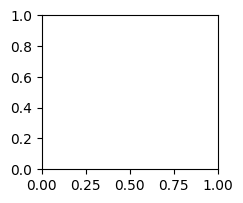

In [136]:
plt.figure(figsize=(5,2))

plt.subplot(1, 2, 1)
results[4]['PValue'].hist()

plt.subplot(1, 2, 2)
results[-3]['PValue'].hist()

### Read results with repeated trials

In [13]:
all_results = []
for numcells in [150]:
    for trial in range(50):        
        name_paths = [
            ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']), 
            ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('edgeR','T4_vs_cM.pseudobulk.edger_lrt.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('DESeq2','T4_vs_cM.pseudobulk.deseq2_wald.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('t-test','T4_vs_cM.sc.ttest.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('MWU','T4_vs_cM.sc.mwu.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('MAST','T4_vs_cM.sc.MAST.{}.{}.csv'.format(numcells, trial), ['coef','Pr(>Chisq)', 'fdr']),
            ('memento', 'T4_vs_cM.sc.weighted_mean_glm.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
        ]
        results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
        gene_lists = [set(res.index) for res in results]
        genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
        results = [res.loc[genes].sort_values('FDR') for res in results]

        scores = [
            (name_paths[idx+4][0].replace('_', '\n'), numcells, concordance_auc(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index)) for idx, res in enumerate(results[4:])]
        all_results+=scores
        
        curves = [
            concordance_curve(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index) for res in results[4:]]

In [14]:
# plt.figure(figsize=(3,3))
# for idx, (x,y) in enumerate(curves):
#     plt.plot(x,y, label=name_paths[idx+4][0])
# plt.legend()
# plt.xlabel('Number of top genes')
# plt.ylabel('Overlap with bulk RNA-seq')

In [15]:
df = pd.DataFrame(all_results, columns=['name', 'numcells', 'auc'])

/tmp/ipykernel_14545/200401537.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_14545/200401537.py:14: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.stripplot(


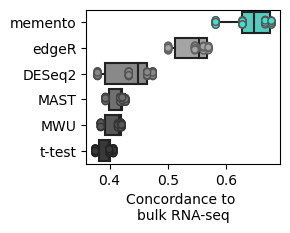

In [23]:
plt.figure(figsize=(2.5,2))
sns.boxplot(
    y='name',
    x='auc', 
    data=df.query('numcells==150'), 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        'MAST',
        'MWU',
        't-test',],
    palette=pal)
sns.stripplot(
    y='name',
    x='auc', 
    data=df.query('numcells==150'), 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        'MAST',
        'MWU',
        't-test',],
    linewidth=1,
    palette=pal)
plt.xlabel('Concordance to \nbulk RNA-seq')
plt.ylabel('')
plt.savefig('lupus_bulk_comparison.pdf', bbox_inches='tight')

### Single example

In [139]:
name_paths = [
    ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.csv', ['logFC','PValue', 'FDR']),
    ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.csv', ['log2FoldChange','pvalue', 'padj']),
    ('pseudobulk_edger','T4_vs_cM.pseudobulk.edger.csv', ['logFC','PValue', 'FDR']),
    ('pseudobulk_deseq2','T4_vs_cM.pseudobulk.deseq2.csv', ['log2FoldChange','pvalue', 'padj']),
    ('ttest','T4_vs_cM.sc.ttest.csv', ['logFC','PValue', 'FDR']),
    ('weighted_mean_GLM', 'T4_vs_cM.sc.weighted_mean_glm.csv', ['logFC','PValue', 'FDR']),
]
results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
gene_lists = [set(res.index) for res in results]
genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
results = [res.loc[genes].sort_values('FDR') for res in results]

curves = [
    concordance_curve(
        results[0].index, 
        results[1].index, 
        results[2].index,
        results[3].index,
        res.index) for res in results[4:]]

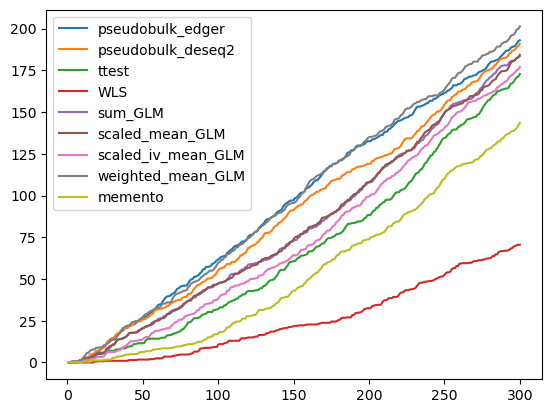

In [142]:
for idx, (x,y) in enumerate(curves):
    plt.plot(x,y, label=name_paths[idx+4][0])
plt.legend()